## Lab 9. Deep Neural Networks
## Recurrent Neural Networks

In this Lab we learn how to solve sequential problems using RNNs. We will describe how can RNNs be implemented with tensorflow and evaluate their results in real problems. 


We will use material from the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. http://shop.oreilly.com/product/0636920052289.do that it is recommended as Bibliography of the course.


In [2]:
# We start by importing the python libraries required to solve the problems

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler


# Tensorflow library used for implementation of the RNNs
import tensorflow as tf
from keras.datasets import imdb, mnist, fashion_mnist
# Importing keras libraries
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, Conv1D, MaxPooling1D
from keras.layers import recurrent
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers.embeddings import Embedding 
from keras.preprocessing import sequence
from keras.utils import to_categorical
import random

import csv
#from sklearn.externals.six.moves.urllib.request import urlopen
!pip install six
from six.moves.urllib.request import urlopen

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl


## Time series prediction with an RNN

The first problem we consider is time series prediction with an RNN. Given a sequence of k contiguous points of the time series, $(t_{r},t_{r+1},\dots,t_{r+k})$ that are used as inputs, we will try to predict the sequence $(t_{r+1},t_{r+2},\dots,t_{r+k+1})$. Therefore, for each single point at time $t$, the target variable is the time series value at time $t+1$.

In [3]:
# This function set the seeds of the tensorflow function
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

The function belows generates a particular time series. 

In [4]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

To train the network we need sequences of size $k$ extracted from the time series. They are randomly selected using the function "next_batch" that outputs a set of <batch_size> training points, each point corresponding to a sequence of size k (in the function this size k is called "n_steps"). 



In [5]:
t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In the next cell, we visualize the time series, and an example of training pairs $(x,y)$, where $x$ is a sequence of $k=20$ points and $y$ is the target sequence of $20$ points, the ones obtained by shifting $x$ only one position. 

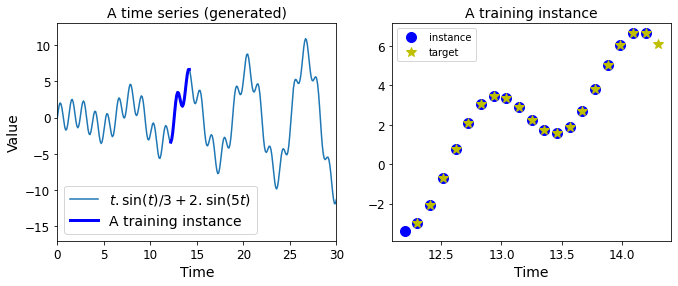

In [7]:
# The time series and the example of (x,y) are shown 

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

#save_fig("time_series_plot")
plt.show()

Now, the parameters of the RNN are defined.

In [8]:
# The computation graph is initialized
reset_graph()

# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 20

# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
# Since we use only a single TS, n_inputs=1
n_inputs = 1

# There is one layer of 100 recurrent neurons together
n_neurons = 100

# The ouput will be a single sequence
n_outputs = 1

# Notice the way the input and output are defined according to n_steps
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In the following notebook cell we specify the type of RNN layer telling tensorflow which RNN cells it comprises. Remember that there are other, more efficient, memory cells, such as LSTM, GRU, etc.  

In this example, a Basic RNN cell is defined, the layer has n_neurons and uses as activation function RELU. 

Finally, the OutputProjectionWrappers adds another layer that transforms the output of the n_neuron neurons into a single value, this function "wraps" the output of the recurrent neurons. 

In [9]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    #tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


As in any other NN, we need to specify the loss function, and optimization algorithm. 

In [10]:
# Learning rate used by the gradient optimizer
learning_rate = 0.001

# The loss function is the Minimum Square Error between the predicted
# TS and the target TS
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

# Optimizer is ADAM
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# We will minimize the MSE
training_op = optimizer.minimize(loss)

# Tensorflow variables are initialized
init = tf.global_variables_initializer()
saver = tf.train.Saver()

The network is trained running "n_iterations" and training batch_size groups of training data. We will save the session at the end so we could use the network to predict new data. 

In [11]:
n_iterations = 2500
batch_size = 50

with  tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 11.967254
100 	MSE: 0.5217673
200 	MSE: 0.150057
300 	MSE: 0.07503032
400 	MSE: 0.06178685
500 	MSE: 0.06005144
600 	MSE: 0.05303566
700 	MSE: 0.047936536
800 	MSE: 0.049633957
900 	MSE: 0.04741607
1000 	MSE: 0.046875343
1100 	MSE: 0.048114453
1200 	MSE: 0.042708833
1300 	MSE: 0.047464177
1400 	MSE: 0.043083463
1500 	MSE: 0.04893733
1600 	MSE: 0.050279576
1700 	MSE: 0.044127114
1800 	MSE: 0.034091935
1900 	MSE: 0.046605326
2000 	MSE: 0.041336205
2100 	MSE: 0.033279736
2200 	MSE: 0.037920974
2300 	MSE: 0.04666444
2400 	MSE: 0.03870371


If training has worked well, then the MSE should have decreased with the iteractions. In the next cell the RNN is used to predict data from 

In [12]:
with  tf.Session() as sess:
    # The session that we saved is restored
    saver.restore(sess, "./my_time_series_model")  
    # A segment of points is taken from the TS
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    # Predictions are made
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_time_series_model


Finally, the true TS values and the predictions are shown

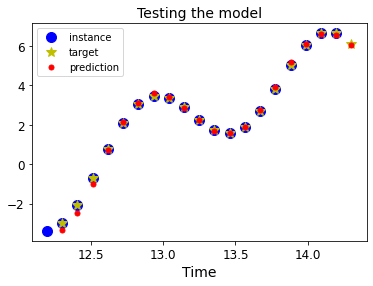

In [13]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

#save_fig("time_series_pred_plot")
plt.show()

## Exercise 1

The first exercise is similar to the previous example, it consists of predicting  the value of a time series (ISE.1 time series in this case) using the same time series until moment $t$. The difference is that we will also use another $7$ time series as input.

We will use the "ISTANBUL STOCK EXCHANGE Data Set" from the UCI website (https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE#). It has been used to forecast the ISE100 index and to determine its daily directional movements. For more information about the meaning of the rate of return of a stock exchange you can see (https://en.wikipedia.org/wiki/Rate_of_return) but this is not relevant for the completion of the exercise. 

To solve the exercise you should: 

Modify the following cells to create an RNN that solves the problem taking into account the following characteristics:

1. Sequence size for prediction: 30
2. Number of neurons: 40
3. You should compare the results of LSTM, GRU, and basic RNN cells (just write down the final MSE values you get with the three types of cells to determine which one is the best).
4. Modify the network to predict the values of the time series taking into consideration the values of the other 7 timeseries, excluding the values of the target time series.  




In [14]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('data_akbilgic.csv')
df

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


The TS that will be predicted is plotted. Notice that it is not as clean as the toy problem shown in the example before.

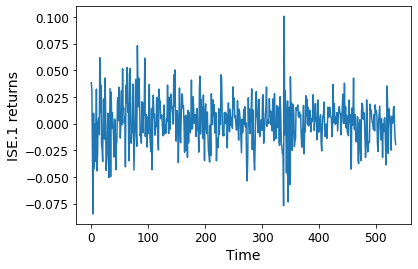

In [15]:
plt.plot(df['ISE.1'])
plt.xlabel("Time")
plt.ylabel("ISE.1 returns")
plt.show()

For a correct estimation of the prediction quality we split the data between train and test in the following cell.

In [16]:
df_size = df.shape[0]
df_train = df.iloc[:int(df_size/2),:]
df_test = df.iloc[int(df_size/2):,:]

The following cell is used to generate batches with which the RNN is trained. 

NOTICE: You will need to modify this function to answer the last part (point 4) of the exercise. But you do not need to change it to answer to complete the other parts. 

In [19]:
# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_stock_batch(batch_size, n_steps, df_base):
    t_min = 0
    t_max = df_base.shape[0]
  
    # The inputs will be formed by 8 sequences taken from
    # 8 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM]
    x = np.zeros((batch_size,n_steps,7))
    
    # We want to predict the returns of the Istambul stock
    # taken into consideration the previous n_steps days
    y = np.zeros((batch_size,n_steps,1))

    # We chose batch_size random points from time series x-axis

    starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)    
    #print(starting_points)

    # We create the batches for x using all time series (8) between t and t+n_steps    
    # We create the batches for y using only one time series between t+1 and t+n_steps+1
    
    for k in np.arange(batch_size):
        lmat = []
        for j in np.arange(n_steps+1):
            lmat.append(df_base.iloc[starting_points[k]+j,2:].to_numpy())  
            mat = np.array(lmat)
        # The x values include all columns (mat[:n_steps,:]), these are ([ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM])
        # and TS values in mat between 0 and n_steps
        x[k,:,:] = mat[:n_steps,1:]
        
        # The y values include only column 0 (mat[1:n_steps+1,0]), this is ([ISE.1]) 
        # and TS values in mat between 1 and n_steps+1
        y[k,:,0] = mat[1:n_steps+1,0]
   

    return x,y

Below is the cell that comprises the definition of the RNN and its input parameters. You should modify this part to answer the questions of the exercise.

In [20]:
# The computation graph is initialized
reset_graph()

# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 30

# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
n_inputs = 7

# There is one layer of 60 recurrent neurons together
n_neurons = 40

# The ouput will be a single sequence
n_outputs = 1

# Notice the way the input and output are defined according to n_steps
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


basic = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)


basic_outputs, basic_states = tf.nn.dynamic_rnn(basic, X, dtype=tf.float32)

# Learning rate used by the gradient optimizer (ADAM)
learning_rate = 0.001

# The loss function is the Minimum Square Error between the predicted
# TS and the target TS
loss_basic = tf.reduce_mean(tf.square(basic_outputs - y)) # MSE

# Optimizer is ADAM
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# We will minimize the MSE
training_basic = optimizer.minimize(loss_basic)


# Tensorflow variables are initialized
init = tf.global_variables_initializer()
saver = tf.train.Saver()


n_iterations = 500
batch_size = 50
printing_gap = 50

with  tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_stock_batch(batch_size, n_steps, df_train)
        
        sess.run(training_basic, feed_dict={X: X_batch, y: y_batch})

        if iteration % printing_gap == 0:
            mse = loss_basic.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tBasic MSE:", mse)

    
    saver.save(sess, "./istambul_model")

0 	Basic MSE: 0.00048610632
50 	Basic MSE: 0.0004732549
100 	Basic MSE: 0.00040462893
150 	Basic MSE: 0.0003995616
200 	Basic MSE: 0.00036606813
250 	Basic MSE: 0.00036950703
300 	Basic MSE: 0.00036279735
350 	Basic MSE: 0.00032167597
400 	Basic MSE: 0.0003059024
450 	Basic MSE: 0.0002820704


In [21]:
# Making prediction for the train dataset (df_train)

with  tf.Session() as sess:
    # The session that we saved is restored
    saver.restore(sess, "./istambul_model")  
    # A segment of points is taken from the TS
    X_new, y_new = next_stock_batch(1, n_steps, df_train)
   
    # Predictions are made
    y_pred = sess.run(basic_outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./istambul_model


We plot the predictions

(1, 30, 1) (1, 30, 1)


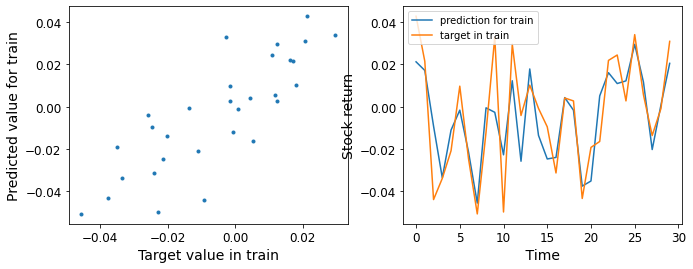

In [22]:
print(y_pred.shape,y_new.shape)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(y_pred.reshape(n_steps),y_new.reshape(n_steps),'.')
plt.xlabel("Target value in train")
plt.ylabel("Predicted value for train")

plt.subplot(122)
plt.plot(y_pred.reshape(n_steps), label="prediction for train")
plt.plot(y_new.reshape(n_steps), label="target in train")
plt.xlabel(" Time ")
plt.ylabel("Stock return")
plt.legend(loc="upper left")

We compute the predictions for the test data

In [23]:
with  tf.Session() as sess:
    # The session that we saved is restored
    saver.restore(sess, "./istambul_model")  
    # A segment of points is taken from the TS
    X_new, y_new = next_stock_batch(1, n_steps, df_test)
   
    # Predictions are made
    y_pred = sess.run(basic_outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./istambul_model


(1, 30, 1) (1, 30, 1)


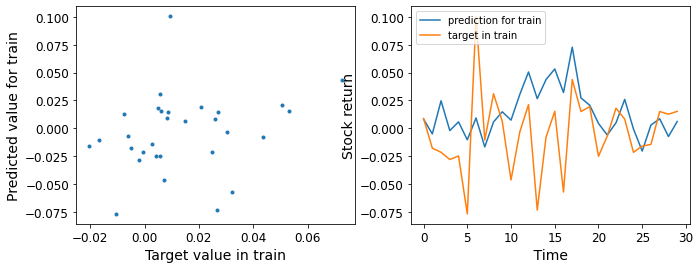

In [24]:
print(y_pred.shape,y_new.shape)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(y_pred.reshape(n_steps),y_new.reshape(n_steps),'.')
plt.xlabel("Target value in train")
plt.ylabel("Predicted value for train")

plt.subplot(122)
plt.plot(y_pred.reshape(n_steps), label="prediction for train")
plt.plot(y_new.reshape(n_steps), label="target in train")
plt.xlabel(" Time ")
plt.ylabel("Stock return")
plt.legend(loc="upper left")

## Solving the MNIST classification problem using an RNN

The next two examples show how to solve the MNIST problem using an RNN and a "deep" RNN of only 3 layers. For the classification problem the idea here is to treat each image as a sequence of 28 rows of 28 pixels each. Therefore the number of steps for the RNN is 28. In each step it uses the current row of the image and the output of the RNN in the previous step to make its prediction. However, in terms of the solution quality, we are only interested in the final prediction of the network (what digit is represented in the image).

Reading the MNIST dataset

In [25]:
def Read_And_Normalize_Image_Dataset(db_name='mnist', max_train_samples = 10000,max_test_samples = 10000):

    if db_name=='mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()               
    elif db_name=='fashion':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()        
        
    #print(x_train.shape,y_train.shape)
    #print(x_test.shape,y_test.shape)

        
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    #x_train = np.expand_dims(x_train, axis=3)
    #x_test = np.expand_dims(x_test, axis=3)
    #x_train = x_train.reshape((len(x_train), 28*28))
    #x_test = x_test.reshape((len(x_test), 28*28))

    return (x_train, y_train), (x_test, y_test) 

The following functions serve to display RGB images


In [26]:
def plot_image(image, vmin=None, vmax=None, greyscale=True):
    plt.imshow(image, cmap="gray" if greyscale else None, interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.show()

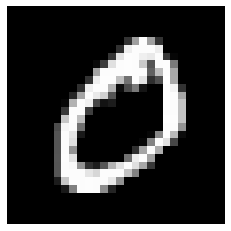

In [27]:
(X_train, y_train), (X_test, y_test) = Read_And_Normalize_Image_Dataset("mnist")

# This line is to test you have downloaded the right dataset
plot_image(X_train[1,:])

### Single-layer RNN

The parameters and the architecture of the one-layer are defined. Pay attention to the size of the inputs and the type of loss function used. 

In [28]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10


learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
print(outputs, states)

# The last layer will be a dense layer
logits = tf.layers.dense(states, n_outputs)

# softmax cross-entropy is the loss function to optimize
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# A classification is correct if the most probable class corresponds
# with the true class
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Tensor("rnn/transpose_1:0", shape=(?, 28, 150), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 150), dtype=float32)
Instructions for updating:
Use keras.layers.dense instead.


The network is trained. 

In [29]:
n_epochs = 15
batch_size = 150

with  tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            random_batch = np.random.randint(0, X_train.shape[0], size=batch_size)
            X_batch, y_batch = X_train[random_batch, :], y_train[random_batch]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9533333 Test accuracy: 0.9373
1 Train accuracy: 0.96 Test accuracy: 0.9407
2 Train accuracy: 0.96666664 Test accuracy: 0.9525
3 Train accuracy: 0.9533333 Test accuracy: 0.9688
4 Train accuracy: 0.96666664 Test accuracy: 0.9634
5 Train accuracy: 0.96666664 Test accuracy: 0.9602
6 Train accuracy: 0.97333336 Test accuracy: 0.97
7 Train accuracy: 0.9866667 Test accuracy: 0.9717
8 Train accuracy: 0.97333336 Test accuracy: 0.9646
9 Train accuracy: 0.96666664 Test accuracy: 0.9677
10 Train accuracy: 0.97333336 Test accuracy: 0.9611
11 Train accuracy: 0.98 Test accuracy: 0.9756
12 Train accuracy: 0.9866667 Test accuracy: 0.9774
13 Train accuracy: 0.99333334 Test accuracy: 0.9785
14 Train accuracy: 0.99333334 Test accuracy: 0.9739


### Three-layer RNN 

See how the architecture of the RNN is created.

In [30]:
reset_graph()


n_steps = 28
n_inputs = 28
n_neurons_1 = 50
n_neurons = 30

n_outputs = 10


learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# We define RNN cells of two different classes
rnn_cell1 = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons_1)

# The cells are stacked within the RNN
stack_rnn = [rnn_cell1]
for i in range(1, 3):
    stack_rnn.append(tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons))
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(stack_rnn, state_is_tuple = True)

outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# We need to transpose the outputs of the network because we are only interested
# in the output of the last row. After transpose  the time axis is first
outputs = tf.transpose(outputs, [1, 0, 2])

# tf.gather() is used for selecting the last frame.
last = tf.gather(outputs, int(outputs.get_shape()[0]) - 1)

# The last layer will be a dense layer connecting all the last outputs
# with a layer of the ten possible outputs we are interested in
logits = tf.layers.dense(last, n_outputs)

# softmax cross-entropy is the loss function to optimize
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# A classification is correct if the most probable class corresponds
# with the true class
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [37]:
n_epochs = 15
batch_size = 150

with  tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            random_batch = np.random.randint(0, X_train.shape[0], size=batch_size)
            X_batch, y_batch = X_train[random_batch, :], y_train[random_batch]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9266667 Test accuracy: 0.9224
1 Train accuracy: 0.94666666 Test accuracy: 0.9495
2 Train accuracy: 0.98 Test accuracy: 0.9622
3 Train accuracy: 0.96666664 Test accuracy: 0.9683
4 Train accuracy: 0.97333336 Test accuracy: 0.9687
5 Train accuracy: 0.97333336 Test accuracy: 0.9777
6 Train accuracy: 0.98 Test accuracy: 0.9752
7 Train accuracy: 1.0 Test accuracy: 0.9782
8 Train accuracy: 0.9866667 Test accuracy: 0.9754
9 Train accuracy: 0.9866667 Test accuracy: 0.9785
10 Train accuracy: 0.9866667 Test accuracy: 0.9802
11 Train accuracy: 0.98 Test accuracy: 0.9798
12 Train accuracy: 0.9866667 Test accuracy: 0.9834
13 Train accuracy: 0.9866667 Test accuracy: 0.9838
14 Train accuracy: 0.99333334 Test accuracy: 0.9836


## Stock prediction with RNNs in Keras

In this example we build RNN architectures to predict the stock market in a period between 2003 and 2008. First, information about 56 stocks is downloaded. 

In [31]:
# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.
#start_date = datetime(2003, 1, 1).date()
#end_date = datetime(2008, 1, 1).date()

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    data = list(csv.DictReader(l.decode('utf8')
                               for l in urlopen(url.format(symbol))))
    quotes.append({'close': [float(rec['close']) for rec in data],
                   'open': [float(rec['open']) for rec in data]})

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

We visualize data for two of the time series, AAPL and AIG indices

Text(0, 0.5, 'Variation')

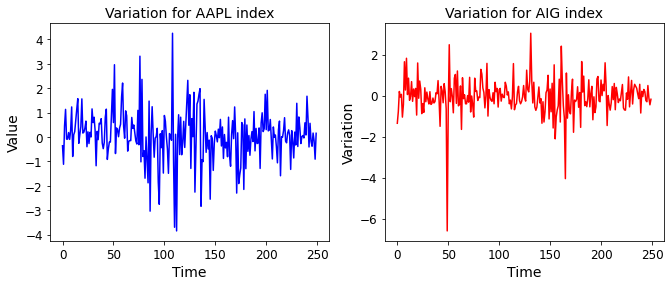

In [32]:
period = np.arange(400,650)
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("Variation for AAPL index", fontsize=14)
plt.plot(variation[0,period],'b')
#plt.plot(variation[1,:],'r.')
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("Variation for AIG index", fontsize=14)
plt.plot(variation[1,period],'r-')
plt.xlabel("Time")
plt.ylabel("Variation")

In [33]:
variation.shape

(56, 1258)

Auxiliary function to create batches for a single time-series

In [34]:
def Create_Data(data,look_back,number_samples):
    n_seq = data.shape[-1]    
    X = np.zeros((number_samples,look_back))
    # We select random positions to get the sequences for learning
    pos =  look_back + np.random.randint(n_seq-look_back,size=number_samples)
    
    # The target variable is the stock time series at that position
    Y = data[pos]
    for i in np.arange(number_samples):
        X[i,:] = data[(pos[i]-look_back):pos[i]]
        
        
    return X,Y

In the first approach we will predict one time series using a sequence of lookup observations from the same time series, i.e., input_features=look_back and output_features=1

The train and test datasets are created. Observe the way in which they are created. 

In [35]:
number_observations = variation.shape[-1]
indices_for_train = np.arange(0,int(number_observations/2))
indices_for_test = np.arange(int(number_observations/2),number_observations)

look_back = 5
nsamples = 1000

trainX, trainY = Create_Data(variation[0,indices_for_train],look_back,nsamples)
testX, testY = Create_Data(variation[0,indices_for_test],look_back,nsamples)


trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX,   (testX.shape[0], testX.shape[1],    1))
trainY = np.reshape(trainY, (trainY.shape[0],1))
testY = np.reshape(testY, (testY.shape[0], 1))

trainX.shape


(1000, 5, 1)

An Simple RNN model is created. 

In [36]:
number_cells = 25

stock_model = Sequential ()
stock_model.add(SimpleRNN(number_cells, input_shape =(look_back, 1) ))
stock_model.add(Dropout(0.2))
stock_model.add (Dense (activation = 'linear',units=1))
stock_model.compile (loss ="mean_squared_error" , metrics=['mse'], optimizer = "adam")  
print(stock_model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 25)                675       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
None


The model is trained and run

In [41]:
nepochs = 50
batch_size = 16
history = stock_model.fit(trainX, trainY, validation_data=(testX,testY), batch_size =batch_size, 
                epochs =nepochs, shuffle = False)


stock_model_train_error = stock_model.evaluate(trainX, trainY, batch_size=batch_size)
stock_model_test_error = stock_model.evaluate(testX, testY, batch_size=batch_size)
print(stock_model_train_error,stock_model_test_error)




Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3487 - mse: 0.3487 - val_loss: 4.3983 - val_mse: 4.3983
Epoch 2/50
10000/10000 [==============================] - 16s 2ms/step - loss: 0.1303 - mse: 0.1303 - val_loss: 4.3890 - val_mse: 4.3890
Epoch 3/50
10000/10000 [==============================] - 16s 2ms/step - loss: 0.0911 - mse: 0.0911 - val_loss: 4.3785 - val_mse: 4.3785
Epoch 4/50
10000/10000 [==============================] - 16s 2ms/step - loss: 0.0726 - mse: 0.0726 - val_loss: 4.3502 - val_mse: 4.3502
Epoch 5/50
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 4.3883 - val_mse: 4.3883
Epoch 6/50
10000/10000 [==============================] - 16s 2ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 4.4056 - val_mse: 4.4056
Epoch 7/50
10000/10000 [==============================] - 16s 2ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 4.3894 - val_

KeyboardInterrupt: 

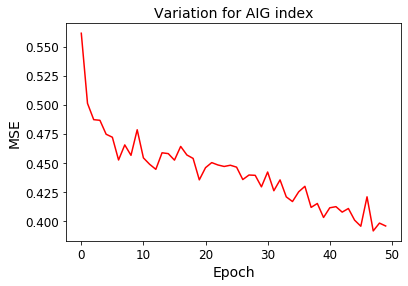

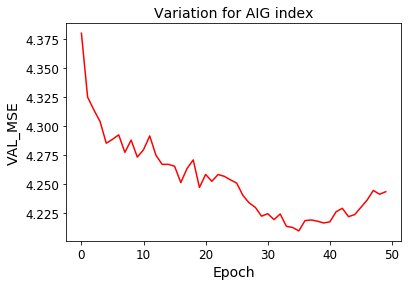

In [50]:
plt.title("Variation for AIG index", fontsize=14)
plt.plot(history.history["mse"],'r-')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()
plt.title("Variation for AIG index", fontsize=14)
plt.plot(history.history["val_mse"],'r-')
plt.xlabel("Epoch")
plt.ylabel("VAL_MSE")
plt.show()

## Exercise 2

In the previous example we predicted the variation for the first stock variation[0,:] using only information about that stock. In the next exercise we would like to use information from all the stocks. 

Function Create_Data_Multiple, creates batches for solving this problem. 

Define a Keras model that contains a single LSTM with 50 cells and one fully connected hidden layer with 50 neurons. Between each layer, include a dropout, with 0.2 probability. Select an adecquate loss function for this problem.

Finally, show the accuracy of the model both in the training set, and in the test set

In [37]:
def Create_Data_Multiple(data,look_back,number_samples,index_to_predict):
    n_seq = data.shape[-1]   
    n_col = data.shape[0] 
    X = np.zeros((number_samples,look_back,n_col))
    # We select random positions to get the sequences for learning
    pos =  look_back + np.random.randint(n_seq-look_back,size=number_samples)
    
    # The target variable is the stock time series at that position
    Y = data[index_to_predict,pos]
    for i in np.arange(number_samples):
        X[i,:,:] = data[:,(pos[i]-look_back):pos[i]].transpose()
        
    return X,Y

In [38]:
nsamples = 10000
look_back = 30
index_to_predict = 0
indices_to_take = np.arange(0,56)
reduced_variation = variation[indices_to_take,:]

trainX, trainY = Create_Data_Multiple(reduced_variation[:,indices_for_train],
                                      look_back,nsamples,index_to_predict)

testX, testY = Create_Data_Multiple(reduced_variation[:,indices_for_test],
                                      look_back,nsamples,index_to_predict)
trainY = np.reshape(trainY, (trainY.shape[0],1))
testY = np.reshape(testY, (testY.shape[0], 1))

testX.shape

(10000, 30, 56)

In [39]:
nepochs = 10
batch_size = 16

In [40]:
number_cells = 50

stock_model = Sequential ()
stock_model.add(SimpleRNN(number_cells, input_shape =(look_back, 56) ))
stock_model.add(Dropout(0.2))
stock_model.add(Dense (activation = 'relu',units=50))
stock_model.add(Dense (activation = 'linear',units=1))
stock_model.compile (loss ="mean_squared_error" , metrics=['mse'], optimizer = "adam")  
print(stock_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                5350      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,951
Trainable params: 7,951
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
nepochs = 50
batch_size = 16
history = stock_model.fit(trainX, trainY, validation_data=(testX,testY), batch_size =batch_size, 
                epochs =nepochs, shuffle = False)


stock_model_train_error = stock_model.evaluate(trainX, trainY, batch_size=batch_size)
stock_model_test_error = stock_model.evaluate(testX, testY, batch_size=batch_size)
print(stock_model_train_error,stock_model_test_error)


Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 9s 855us/step - loss: 0.3591 - mse: 0.3591 - val_loss: 4.5237 - val_mse: 4.5237
Epoch 2/50
10000/10000 [==============================] - 8s 838us/step - loss: 0.1369 - mse: 0.1369 - val_loss: 4.6640 - val_mse: 4.6640
Epoch 3/50
10000/10000 [==============================] - 8s 836us/step - loss: 0.0977 - mse: 0.0977 - val_loss: 4.6331 - val_mse: 4.6331
Epoch 4/50
10000/10000 [==============================] - 8s 846us/step - loss: 0.0796 - mse: 0.0796 - val_loss: 4.5922 - val_mse: 4.5922
Epoch 5/50
10000/10000 [==============================] - 9s 857us/step - loss: 0.0716 - mse: 0.0716 - val_loss: 4.5531 - val_mse: 4.5531
Epoch 6/50
10000/10000 [==============================] - 8s 827us/step - loss: 0.0639 - mse: 0.0639 - val_loss: 4.5876 - val_mse: 4.5876
Epoch 7/50
10000/10000 [==============================] - 8s 820us/step - loss: 0.0570 - mse: 0.0570 - val_loss: 4.6027 - 

### Tensorflow implementation of a RNN

In the following cell, we set common parameters of a RNN implementation. 

In [42]:
seed = 1

tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_epochs = 500
total_series_length = 10000
truncated_backprop_length = 20
state_size = 4
batch_size = 20
num_batches = total_series_length//batch_size//truncated_backprop_length

We are also going to redefine the time series we are working with, so that the values are independent of the place we take the batch from

In [43]:
def time_series(t):
    return  np.sin(t) / 3 + 2 * np.sin(t*5)

t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_batch(btch_sz, n_steps):
    t0 = np.random.rand(btch_sz, 1) * (t_max - t_min - n_steps * resolution)
    ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(ts)
    return ys[:, :-1].reshape(-1, n_steps), ys[:, 1:].reshape(-1, n_steps)

In [44]:
X = tf.placeholder(tf.float32, [None, truncated_backprop_length])
Y = tf.placeholder(tf.int32, [None, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [None, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,1)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unstack(X, axis=1)
g_truth_series = tf.unstack(Y, axis=1)

print(len(inputs_series), X)
saver = tf.train.Saver()

20 Tensor("Placeholder_4:0", shape=(?, 20), dtype=float32)


Definition of the recurrent part of the network:

In [45]:
current_state = init_state
states_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input, [-1, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  
    states_series.append(next_state)
    current_state = next_state

predictions_series = [tf.matmul(state, W2) + b2 for state in states_series] 

In [46]:
losses = [tf.losses.mean_squared_error(pred, tf.reshape(val, (-1,1))) for pred, val in zip(predictions_series, g_truth_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.001).minimize(total_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    for epoch_idx in range(num_epochs):
        x,y = next_batch(batch_size, total_series_length)

        _current_state = np.zeros((batch_size, state_size))


        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            #print(batchY.shape)

            _total_loss, _train_step, _current_state = sess.run([total_loss, train_step, current_state],feed_dict={X:batchX, Y:batchY, init_state:_current_state})


        print("Epoch",epoch_idx, "Loss", _total_loss)


    saver.save(sess, "./myRNN")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0 Loss 4.7157035
Epoch 1 Loss 4.552162
Epoch 2 Loss 4.4604526
Epoch 3 Loss 4.3303423
Epoch 4 Loss 4.286826
Epoch 5 Loss 4.3128495
Epoch 6 Loss 4.3620152
Epoch 7 Loss 4.2146454
Epoch 8 Loss 4.131078
Epoch 9 Loss 4.1816187
Epoch 10 Loss 4.062305
Epoch 11 Loss 4.0450096
Epoch 12 Loss 3.9237437
Epoch 13 Loss 3.9088397
Epoch 14 Loss 3.881649
Epoch 15 Loss 3.8693192
Epoch 16 Loss 3.8542
Epoch 17 Loss 3.818931
Epoch 18 Loss 3.8106666
Epoch 19 Loss 3.750649
Epoch 20 Loss 3.643745
Epoch 21 Loss 3.6740582
Epoch 22 Loss 3.5571437
Epoch 23 Loss 3.6595147
Epoch 24 Loss 3.5605736
Epoch 25 Loss 3.5238812
Epoch 26 Loss 3.4628463
Epoch 27 Loss 3.5132184
Epoch 28 Loss 3.5459542
Epoch 29 Loss 3.374345
Epoch 30 Loss 3.4382935
Epoch 31 Loss 3.3879082
Epoch 32 Loss 3.3874435
Epoch 33 Loss 3.3928611
Epoch 34 Loss 3.3642719
Epoch 35 Loss 3.3368409
Epoch 36 Loss 3.3392417
Epoch 37 Loss 3.3565788
Epoch 38 Loss 3.2850425
Epoch 39 Los

INFO:tensorflow:Restoring parameters from ./myRNN
(20, 20, 1) (20, 20)


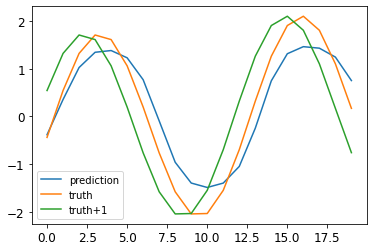

In [48]:
with tf.Session() as sess:

    saver.restore(sess, "./myRNN")

    x, y = next_batch(batch_size, truncated_backprop_length)

    p = np.array(sess.run(predictions_series, feed_dict={X: x, init_state: np.zeros((batch_size, state_size))}))

    print(p.shape, x.shape)

    plt.plot(p[:,0], label="prediction")
    plt.plot(x[0,:], label="truth")
    plt.plot(y[0,:], label="truth+1")

    plt.legend()
    plt.show()

## Exercise 3
### Solving the MNIST classification problem using an RNN.

Below is an incomplete model of an application of an LSTM to solve the MNIST problem. Here, we want to solve the same problem that was treated before Exercise 2, but using Keras instead of tensorflow.

For that, we define a model onsisting of a single LSTM with 50 neurons, and a single dense layer. Therefore, the model will only have one single hidden layer, with 50 neurons.

After training the model, obtain its accuracy in the test set.


In [49]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) \
                                = Read_And_Normalize_Image_Dataset(db_name='mnist', \
                                max_train_samples = 10000, max_test_samples = 10000)


print("Dimension of the samples in the training set: ", x_mnist_train.shape)
print("Dimension of samples in the test set: ", x_mnist_test.shape)

number_mnist_classes = 10
y_mnist_train_one_hot  = to_categorical(y_mnist_train)
y_mnist_test_one_hot  = to_categorical(y_mnist_test)

print("Dimension of the labels training set (one_hot): ", y_mnist_train_one_hot.shape)
print("Dimension of the labels test set (one_hot): ", y_mnist_test_one_hot.shape)

Dimension of the samples in the training set:  (60000, 28, 28)
Dimension of samples in the test set:  (10000, 28, 28)
Dimension of the labels training set (one_hot):  (60000, 10)
Dimension of the labels test set (one_hot):  (10000, 10)


In [50]:
number_neurons = 50
time_steps = 1
n_inputs = 28
number_classes = 10
number_epochs = 10
batch_size = 200
nepochs = 5

In [51]:
number_cells = 50

mnist_model = Sequential ()
mnist_model.add(SimpleRNN(number_cells, input_shape =(28, 28) ))
mnist_model.add(Dropout(0.2))
mnist_model.add(Dense (activation = 'relu',units=50))
mnist_model.add(Dense (activation = 'softmax',units=10))
mnist_model.compile(loss ="categorical_crossentropy" , metrics=['acc'], optimizer = "adam")  
print(mnist_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                3950      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 7,010
Trainable params: 7,010
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
history = mnist_model.fit(x_mnist_train, y_mnist_train_one_hot, validation_data=(x_mnist_test,y_mnist_test_one_hot), 
                          batch_size=batch_size, epochs=nepochs, shuffle = False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 159us/step - loss: 0.9791 - acc: 0.6828 - val_loss: 0.4707 - val_acc: 0.8542
Epoch 2/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.4507 - acc: 0.8626 - val_loss: 0.3394 - val_acc: 0.8952
Epoch 3/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.3542 - acc: 0.8937 - val_loss: 0.2725 - val_acc: 0.9162
Epoch 4/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.3043 - acc: 0.9094 - val_loss: 0.2461 - val_acc: 0.9268
Epoch 5/5
60000/60000 [==============================] - 8s 125us/step - loss: 0.2680 - acc: 0.9200 - val_loss: 0.2332 - val_acc: 0.9298


In [53]:
preds = np.argmax(mnist_model.predict(x_mnist_test), axis=1)
print("The accuracy on test data was:", str(np.sum(1*(y_mnist_test == preds))/preds.shape[0]*100), "%")

The accuracy on test data was: 92.97999999999999 %


## Exercise 4

We have taken advantage of the RNN implementations available in both Keras and Tensorflow. Now, we are digging one step deeper into the implementation, by implementing RNN cells ourselves. Following the example, define different variants of the common RNN (e.g., LSTM or GRU). Take a look at https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767.

Try to improve the results obtained by the tensorflow RNN defined for the sinusoidal example